In [174]:
# import numpy as np
import pandas as pd
from IPython.display import display
import random
import math
import os 
import sys

import matplotlib
import matplotlib.pyplot as plt

from collections import namedtuple, deque
from statistics import mean
from itertools import count

import numpy
import torch
import torch as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [175]:
implicit_num_threads = 12
os.environ["OMP_NUM_THREADS"] = str(implicit_num_threads)
os.environ["MKL_NUM_THREADS"] = str(implicit_num_threads)
os.environ["OPENBLAS_NUM_THREADS"] = str(implicit_num_threads)
torch.set_printoptions(threshold=sys.maxsize)

In [176]:
class gomoku_game:
    def __init__(self):
        self.dim = 15 #15x15 board, can be 19x19
        self.state = np.zeros([self.dim, self.dim], dtype=np.int8)
        self.players = {'p1': 1, 'p2': 2} 
        self.isDone = False
        self.reward = {'win': 1, 'draw': 0.5, 'loss': -1}
        self.available = [] #initialize to all spots on board
        for i in range(self.dim):
            for j in range(self.dim):
                self.available.append(i + j* self.dim)
    
    def render(self): #rev
        rendered_board_state = self.state.numpy(force=True).astype(str)
        rendered_board_state[self.state == 0] = ' '
        rendered_board_state[self.state == 1] = 'B'
        rendered_board_state[self.state == 2] = 'W'
        display(pd.DataFrame(rendered_board_state))
    
    def reset(self): #rev
        self.__init__()
        
    def get_available_actions(self):
        return self.available
    

    def check_game_done(self, player, last):
        def check_flat(state, i, j):
            ci = i
            while ci > 0 and state[ci][j] == state[i][j]: 
                ci -= 1
            if state[ci][j] != state[i][j]:
                left = ci + 1
            else:
                left = ci
            ri = i
            while ri < (len(state) - 1) and state[ri][j] == state[i][j]: 
                ri += 1 
            if state[ri][j] != state[i][j]:
                right = ri - 1
            else:
                right = ri
            if right - left >= 4: 
                return True 
            return False

        '''
        find length of current diag with equal values and if over 4 return true 
        '''
        def check_diag(state, i, j):
            li = i
            lj = j
            while li > 0 and lj > 0 and state[li][lj] == state[i][j]:
                li -= 1
                lj -= 1
            if state[li][lj] != state[i][j]:
                lowi = li + 1
                lowj = lj + 1
            else:
                lowi = li
                lowj = lj

            ui = i
            uj = j
            while ui < len(state) - 1 and uj < len(state) - 1 and state[ui][uj] == state[i][j]:
                ui += 1
                uj += 1
            if state[ui][uj] != state[i][j]:
                upi = ui - 1
                upj = uj - 1
            else:
                upi = ui
                upj = uj

            if upi - lowi >= 4: 
                return True
            return False

        '''
        input:
            state: board state (15x15 numpy array)
        output:
            win: boolean value of whether current player won
        '''
        
        #check diagonal
        #check horizontal
        #check vertical
        i, j = last
        # stateCp = self.state.copy()

        vert = check_flat(self.state, i, j)  #I dont believe these need to be copied
        horiz = check_flat(self.state.T, j, i)
        
        # print("hor" + str(horiz))
        # print("vert" + str(vert))
        
        #i think this should work??
        diagl = check_diag(self.state, i, j)
        diagr = check_diag(np.fliplr(self.state), i, len(self.state) -1 - j)

        diag = diagl or diagr

        return (horiz or vert) or diag


    def make_move(self, a, player):
        # check if move is valid
        i = a % self.dim
        j = int((a - i)/ self.dim)
        openSpots = self.get_available_actions()
        if a in openSpots:
            self.state[i,j] = self.players[player]
            self.available.remove(a)
        else:
            self.render()
        a = (i, j)
        win = self.check_game_done(player, a)

        reward = 0.
        if len(openSpots) == 0:
            reward = self.reward['draw']
            self.isDone = True
        elif win:  
            reward = self.reward['win']
            self.isDone = True

        # give feedback as new state and reward
        # return self.state.copy(), reward
        return self.state.detach().clone(), reward

env = gomoku_game()

In [177]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [178]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state'))


#***based on torch tutorial
class ReplayMemory(object):

    def __init__(self):
        self.memory = deque([])

    #could use *args for historical turns? 
    def push(self, *args):
        # self.memory.append(Transition(*args))
        self.memory.append(Transition(*args)) #dequeified

    def pushAll(self, TranList):
        # self.memory.extend(TranList) # list version
        self.memory = self.memory + TranList

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
memory = ReplayMemory()

In [179]:
class OldDQN(nn.Module):
    def __init__(self, outputs):
        super(OldDQN, self).__init__()
        # 6 by 7, 10 by 11 
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        # self.pool = nn.MaxPool2d((5,5))
        self.conv4 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.conv6 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.conv7 = nn.Conv2d(32, 32, kernel_size=5, padding=2)

        # linear_input_size = 6 * 7 * 32
        self.MLP1 = nn.Linear(7200, 512)
        self.MLP2 = nn.Linear(512, 512)
        self.MLP3 = nn.Linear(512, 512)
        self.MLP4 = nn.Linear(512, outputs)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        # x = self.pool(x)
        x = F.leaky_relu(self.conv4(x))
        x = F.leaky_relu(self.conv5(x))
        x = F.leaky_relu(self.conv6(x))
        x = F.leaky_relu(self.conv7(x))
        # flatten the feature vector except batch dimension
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.MLP1(x))
        x = F.leaky_relu(self.MLP2(x))
        x = F.leaky_relu(self.MLP3(x))
        return self.MLP4(x)
    

# def DQN (outputs):
#     model = nn.Sequential(
#         nn.Conv2d(1, 32, kernel_size=(7,7), padding=2), 
#         nn.BatchNorm2d(32),
#         nn.ReLU(),
#         nn.Conv2d(32, 32, kernel_size=(7,7), padding=2),
#         nn.BatchNorm2d(32),
#         nn.ReLU(),
#         # nn.MaxPool2d((2,2)),
#         nn.Conv2d(32, 64, kernel_size=(7,7), padding=2),
#         nn.BatchNorm2d(64),
#         nn.ReLU(),
#         # nn.MaxPool2d((2,2)),
#         nn.Flatten(),
#         nn.Linear(5184, 1024),
#         nn.ReLU(),
#         nn.Linear(1024, outputs),
#     )
#     return model

In [180]:
steps_done = 0
training_history = []
loss_sum = []

In [181]:
PATH = "200Epoch-7conv-4linear/model.pth"
old_model = OldDQN(env.dim **2).to(device)
old_model.load_state_dict(torch.load(PATH))
old_model.eval()

OldDQN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv5): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv6): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv7): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (MLP1): Linear(in_features=7200, out_features=512, bias=True)
  (MLP2): Linear(in_features=512, out_features=512, bias=True)
  (MLP3): Linear(in_features=512, out_features=512, bias=True)
  (MLP4): Linear(in_features=512, out_features=225, bias=True)
)

In [182]:
class DQN2(nn.Module):
    def __init__(self, outputs):
        super(DQN2, self).__init__()
        # 6 by 7, 10 by 11 
        self.conv1 = nn.Conv2d(1, 32, kernel_size=7, padding=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=7, padding=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=7, padding=2)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.conv6 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.conv7 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.conv8 = nn.Conv2d(128, 128, kernel_size=3, padding=2)
        self.conv9 = nn.Conv2d(128, 128, kernel_size=3, padding=2)
        self.conv10 = nn.Conv2d(128, 128, kernel_size=3, padding=2)
        self.conv11 = nn.Conv2d(128, 128, kernel_size=3, padding=2)
        self.MLP1 = nn.Linear(8*16*17*17, 1024)
        self.MLP2 = nn.Linear(1024, 1024)
        self.MLP4 = nn.Linear(1024, outputs)
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        # x = self.pool(x)
        x = F.leaky_relu(self.conv4(x))
        x = F.leaky_relu(self.conv5(x))
        x = F.leaky_relu(self.conv6(x))
        x = F.leaky_relu(self.conv7(x))
        x = F.leaky_relu(self.conv8(x))
        x = F.leaky_relu(self.conv9(x))
        x = F.leaky_relu(self.conv10(x))
        x = F.leaky_relu(self.conv11(x))
        # flatten the feature vector except batch dimension
        x = x.view(x.size(0), -1)
        x = F.leaky_relu(self.MLP1(x))
        x = F.leaky_relu(self.MLP2(x))
        # x = F.leaky_relu(self.MLP3(x))
        return self.MLP4(x)

In [183]:
#params
B = 256 #batch size - 256 on smaller board size was very good
gamma = 0.9999 #0.999 or 0.9999 or decrease?
lr = 1e-2
eps_start = 0.9
eps_end = 0.05
eps_decay = 200
tau = 0.005

bSize = env.dim #board dimensions
n_actions = bSize **2


policy_net = DQN2(n_actions).to(device)
target_net = DQN2(n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
policy_net.train()

# target_net.eval() # set target net into eval mode
optimizer = optim.Adam(policy_net.parameters(), amsgrad=True)

In [184]:
def select_action(state, available_actions, training=True):
    current_chance = random.random()
    
    #available_actions = state.get_available_actions()
    if training:
        global steps_done
        eps_threshold = eps_end + (eps_start - eps_end) * math.exp(-1 * steps_done / eps_decay)
        # eps_threshold = eps_start + (eps_start - eps_end) * math.exp(-1 * 0)
    else:
        eps_threshold = 0
    if current_chance > eps_threshold:
    # if True:
        with torch.no_grad():
            all_probabilities = policy_net(state.detach().clone().to(
        'mps', dtype=torch.float32).unsqueeze(dim=0).unsqueeze(dim=0))[0, :] #unsqez
            potential_action_probs = [all_probabilities[a] for a in available_actions]
            return available_actions[np.argmax(torch.tensor(potential_action_probs))] #Always pick most likely - could use an additional layer of randomness for fun tho?
    else: 
        return random.choice(available_actions)

In [185]:
#Optimization of model 

def optimize_model():
    if len(memory) < B:
        return

    transitions = memory.sample(B)
    batch = Transition(*zip(*transitions))

    # state_batch, action_batch, reward_batch, next_state_batch = zip(*[(np.expand_dims(m[0], axis=0), \
    #                                     [m[1]], m[2], np.expand_dims(m[3], axis=0)) for m in transitions])


    #WORKS ON CPU
    state_batch = torch.from_numpy(numpy.asarray(batch.state, dtype=numpy.float32)).to(
        'mps', dtype=torch.float32).unsqueeze(1)
    # action_batch = torch.from_numpy(numpy.asarray(batch.action, dtype=numpy.float32)).to(
    #     'mps', dtype=torch.float32)
    tempGARBAGE1 = []
    for aa in batch.action:
        if aa is not None:
            tempGARBAGE1.append([aa]) 

    action_batch = torch.tensor(tempGARBAGE1, dtype=torch.float32, device='mps')
    reward_batch = torch.from_numpy(numpy.asarray(batch.reward, dtype=numpy.float32)).to(
        'mps', dtype=torch.float32)
    # next_batch = np.expand_dims(batch.next_state, axis=0)


    tempGARBAGE = []
    for s_ in batch.next_state:
        if s_ is not None:
            tempGARBAGE.append(s_) 

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device)
    
    non_final_next_states = torch.from_numpy(numpy.asarray(tempGARBAGE, dtype=numpy.float32)).to(
        'mps', dtype=torch.float32)
    

    state_action_values = policy_net(state_batch).gather(1, action_batch.to(
        'mps', dtype=torch.long))


    next_state_values = torch.zeros(B, device=device)
    
    with torch.no_grad():
        temp = target_net(non_final_next_states.unsqueeze(1)).max(1).values
        # temp = target_net(non_final_next_states.unsqueeze(1))
        # print(target_net(non_final_next_states.unsqueeze(1)).max(1)[0].detach())
        next_state_values[non_final_mask] = target_net(non_final_next_states.unsqueeze(1)).max(1)[0].detach()
        
        # target_net(non_final_next_states.unsqueeze(1)).max(1)
    
    # compute the expected Q values
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # print(reward_batch.unsqueeze(1))
    # print(expected_state_action_values.unsqueeze(1))

    loss_sum.append(loss)

    optimizer.zero_grad()
    loss.backward()
    # nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()
    




In [186]:
# random agent
def random_agent(state, actions, training=False):
    return random.choice(actions)


def select_old_agent(state, available_actions, training=False):
    # with torch.no_grad():
    all_probabilities = old_model(state.detach().clone().to(
    device, dtype=torch.float32).unsqueeze(dim=0).unsqueeze(dim=0))[0, :] #unsqez
    potential_action_probs = [all_probabilities[a] for a in available_actions]
    return available_actions[np.argmax(torch.tensor(potential_action_probs))] 


# win rate test
def win_rate_test():
    policy_net.eval()
    EVAL_EPOCHS = 100
    win_moves_taken_list = []
    win = []
    for i in range(EVAL_EPOCHS):
        env.reset()
        win_moves_taken = 0
        state = env.state.clone()
        while not env.isDone:
            rando = random.randint(0,7)

            available_actions = env.get_available_actions()
            # if rando != 5:
            action = select_action(state, available_actions, training=True)
            # action = act1(state, available_actions, training=True)
            # else:
            #     action = select_old_agent(state, available_actions)
            state, reward = env.make_move(action, 'p1')
            win_moves_taken += 1

            if reward == 1:
                win_moves_taken_list.append(win_moves_taken)
                win.append(1)
                break

            available_actions = env.get_available_actions()
            # action = random_agent(state, available_actions, training=True)
            # action = select_old_agent(state, available_actions)
            # if rando != 3:
            action = select_action(state, available_actions, training=False)
            # action = act2(state, available_actions, training=False)
            # else:
            #     action = select_old_agent(state, available_actions)
            state, reward = env.make_move(action, 'p2')
    policy_net.train()
    if len(win_moves_taken_list) == 0: 
        win_moves_taken_list.append(-1)
    return sum(win)/EVAL_EPOCHS, mean(win_moves_taken_list)

In [187]:
def eligibility_trace(trans_list, lambda_trace): #is a deque
    main_val = trans_list[0][2]
    out = deque([])
    for i in range(0, len(trans_list)):
        inter = (trans_list[i][0], trans_list[i][1], main_val * (lambda_trace ** (i)), trans_list[i][3])
        out.append(inter)
        if i > 4:
            for j in range(6, len(trans_list)):
                out.append(trans_list[j])
            break

    return out

In [189]:

# print(eps_decay)
num_episodes = 50
# control how lagged is target network by updating every n episodes
TARGET_UPDATE = 100

for i in range(num_episodes): 
    env.reset()
    state_p1 = env.state.clone()
    # record every 20 epochs
    if i % 10 == 9:
        win_rate, moves_taken = win_rate_test()
        training_history.append([i + 1, win_rate, moves_taken])
        # th = np.array(training_history)
        # print training message every 200 epochs
        if i % 1 == 0:
            print('Episode {}: | win_rate: {} | moves_taken: {}'.format(i, training_history[-1][1], training_history[-1][2]))
    # break
    tempMem = deque([]) #Switch to deque
    lambda_trace = .2
    for t in count():
        available_actions = env.get_available_actions()
        action_p1 = select_action(state_p1, available_actions, True)
        steps_done += 1
        state_p1_, reward_p1 = env.make_move(action_p1, 'p1')

        if env.isDone:
            if reward_p1 == 1:
                # reward p1 for p1's win
                memory.push(state_p1, action_p1, 1, None)
                #tempMem.appendleft((state_p1, action_p1, 1, None))
            else:
                # state action value tuple for a draw
                memory.push(state_p1, action_p1, 0.5, None)
                #tempMem.appendleft((state_p1, action_p1, 0.5, None))
            
            break
        
        available_actions = env.get_available_actions()
        # action_p2 = random_agent(available_actions)
        action_p2 = select_action(state_p1_, available_actions, False)
        state_p2_, reward_p2 = env.make_move(action_p2, 'p2')
        
        if env.isDone:
            if reward_p2 == 1:
                # punish p1 for (random agent) p2's win 
                memory.push(state_p1, action_p1, -1,None)
                #tempMem.appendleft((state_p1_, action_p1, -1,None))
            else:
                # state action value tuple for a draw
                memory.push(state_p1, action_p1, 0.5, None)
                #tempMem.appendleft((state_p1_, action_p1, 0.5, None))
            break
        
        # punish for taking too long to win
        memory.push(state_p1_, action_p1, -0.05, state_p2_)
        # tempMem.appendleft((state_p1_, action_p1, -0.05, state_p2_))
        state_p1 = state_p2_
        
    # tempupdate = eligibility_trace(tempMem, lambda_trace)
    # memory.pushAll(tempupdate)
    # print(tempupdate)
        # Perform one step of the optimization (on the policy network)
        optimize_model()

    # update the target network, copying all weights and biases in DQN
    if i % TARGET_UPDATE == TARGET_UPDATE - 1:
        target_net.load_state_dict(policy_net.state_dict())



# path = 'BEEFY-7conv-4linear_200Epoch-rando.pth'
# torch.save(policy_net.state_dict(), path)

print('Complete')

Episode 9: | win_rate: 0.54 | moves_taken: 55.2962962962963
Episode 19: | win_rate: 0.23 | moves_taken: 53.73913043478261
Episode 29: | win_rate: 0.68 | moves_taken: 49.23529411764706
Episode 39: | win_rate: 0.35 | moves_taken: 56.22857142857143
Episode 49: | win_rate: 0.66 | moves_taken: 52.92424242424242
Complete


In [40]:
print(len(memory))

4997


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


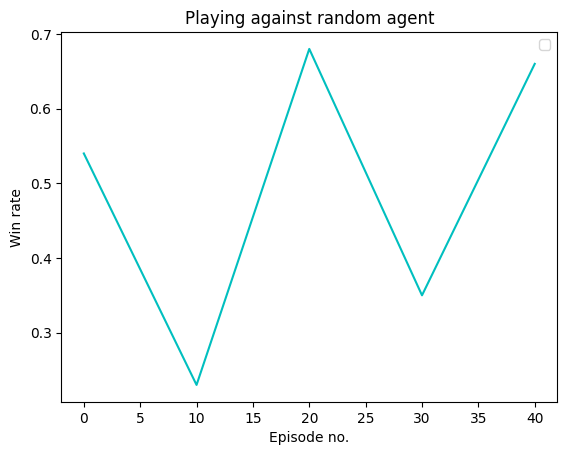

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


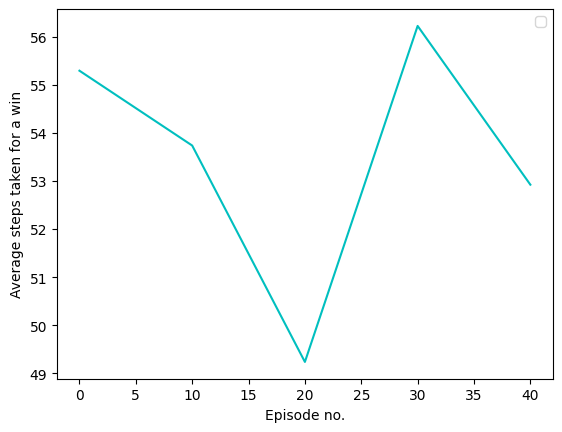

0.010046985931694508


[]

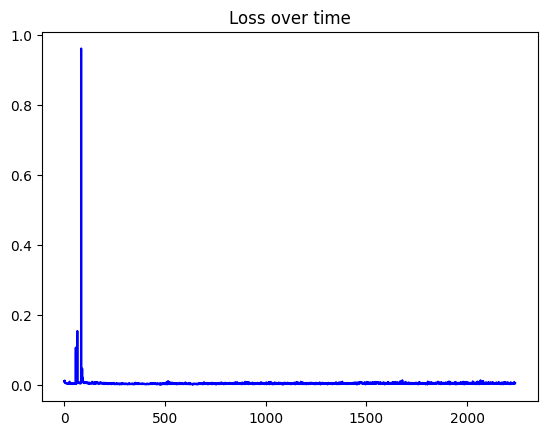

In [190]:
th = numpy.array(training_history)
recorded = 10
xAxislength= len(th[:, 0]) * recorded
plt.plot(numpy.arange(xAxislength, step=recorded), th[:, 1], c='c')
# win_rate_moving_average = numpy.array([[(i + (recorded - 1)) * recorded, numpy.mean(th[i: i + recorded, 1])] for i in range(len(th) - recorded-1)])
# win_rate_moving_average = [numpy.mean(th[i: i + recorded, 1]) for i in range(len(th) - recorded-1)]
# print(len(win_rate_moving_average))
win_rate_moving_average = numpy.array([[(i + 19) * 20, numpy.mean(th[i: i + 20, 1])] for i in range(len(th) - 19)])
# plt.plot(win_rate_moving_average[:,0],  win_rate_moving_average[:,1], c='b', label='moving average of win rate')
plt.legend()
plt.title('Playing against random agent')
plt.xlabel('Episode no.')
plt.ylabel('Win rate')
plt.show()

plt.plot(numpy.arange(xAxislength, step=recorded), th[:, 2], c='c')
win_steps_taken_moving_average = numpy.array([[(i + 19) * 20, numpy.mean(th[i: i + 20, 2])] for i in range(len(th) - 19)])
# plt.plot(win_steps_taken_moving_average[:, 0], win_steps_taken_moving_average[:, 1], c='b', label='moving average of win steps taken')
plt.legend()
plt.xlabel('Episode no.')
plt.ylabel('Average steps taken for a win')
plt.show()


plt.clf()
print(loss_sum[0].item())
ar = numpy.arange(len(loss_sum))
# ar = numpy.arange(400, 1000)
sece = []
for s in loss_sum:
    sece.append(s.item())
plt.plot(ar, sece, c='b')
plt.title("Loss over time")
plt.plot()

In [113]:
def demo():
    env.reset()
    env.render()
    ind = 0
    turnRef = ['p1', 'p2']
    state = env.state.clone()
    while not env.isDone:
        available_actions = env.get_available_actions()
        action = select_action(state, available_actions, training=False)
        # trained agent's move is denoted by O
        state, reward = env.make_move(action, turnRef[ind])
        ind+=1
        env.render()

        if reward == 1:
            print('p1')
            break
        
        available_actions = env.get_available_actions()
        action = random_agent(available_actions)
        # action = select_action(state, available_actions, training=False)
        state, reward = env.make_move(action, turnRef[ind])
        ind-=1
        env.render()
        if reward == 1:
            print('p2')
            break


demo()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,
1,,,,,,,,,,,,,,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,,,,,,,,,,,,,,,
5,,,,,,,,,,,,,,,
6,,,,,,,,,,,,,,,
7,,,,,,,,,,,,,,,
8,,,,,,,,,,,,,,,
9,,,,,,,,,,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,
1,,,,,,,,,,,,,,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,,,,,,,,B,,,,,,,
5,,,,,,,,,,,,,,,
6,,,,,,,,,,,,,,,
7,,,,,,,,,,,,,,,
8,,,,,,,,,,,,,,,
9,,,,,,,,,,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,,,,,,,,B,,,,,,,
5,,,,,,,,,,,,,,,
6,,,,,,,,,,,,,,,
7,,,,,,,,,,,,,,,
8,,,,,,,,,,,,,,,
9,,,,,,,,,,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,,,,,,,,B,,,,,,,
5,,,,,,,,,,,,,,,
6,,,,,,,,,,,,,,,
7,,,,,,,,,,B,,,,,
8,,,,,,,,,,,,,,,
9,,,,,,,,,,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,,,,,,,,B,,,W,,,,
5,,,,,,,,,,,,,,,
6,,,,,,,,,,,,,,,
7,,,,,,,,,,B,,,,,
8,,,,,,,,,,,,,,,
9,,,,,,,,,,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,,,,,,,,B,,,W,,,,
5,,,,,,,,,,,,,,,
6,,,,,,,,,,,,,,,
7,,,,,,,,,,B,,,,,
8,,,,,,B,,,,,,,,,
9,,,,,,,,,,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,W,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,,,,,,,,B,,,W,,,,
5,,,,,,,,,,,,,,,
6,,,,,,,,,,,,,,,
7,,,,,,,,,,B,,,,,
8,,,,,,B,,,,,,,,,
9,,,,,,,,,,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,W,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,,,,,,,,B,,,W,,,,
5,,,,,,,,,,,,,,,
6,,,,,,,,,,,,,,,
7,,,,,,,,,,B,,,,,
8,,,,,,B,,,,,,,,,
9,,,,,,,,,,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,W,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,,,,,,,,B,,W,W,,,,
5,,,,,,,,,,,,,,,
6,,,,,,,,,,,,,,,
7,,,,,,,,,,B,,,,,
8,,,,,,B,,,,,,,,,
9,,,,,,,,,,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,W,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,,,,,,,,B,,W,W,,,,
5,,,,,,,,,,,,,,,
6,,,,,,,,,,,,,,,
7,,,,,,,,,,B,,,,,
8,,,,,,B,,,,,,,,,
9,,,,,,,,,,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,W,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,,,,,,,,B,,W,W,,,,
5,,,,,,,,,,,,,,,
6,,W,,,,,,,,,,,,,
7,,,,,,,,,,B,,,,,
8,,,,,,B,,,,,,,,,
9,,,,,,,,,,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,W,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,,,,,,,,B,,W,W,,,,B
5,,,,,,,,,,,,,,,
6,,W,,,,,,,,,,,,,
7,,,,,,,,,,B,,,,,
8,,,,,,B,,,,,,,,,
9,,,,,,,,,,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,W,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,,,,,,,,B,,W,W,,,,B
5,,,,,,,,,,,,,,,
6,,W,,,,,,,,,,,,,
7,,,,,,,,,,B,,,,,
8,,,,,,B,,,,,,,,,
9,,,,,,,,,,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,W,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,,,,,,,,B,,W,W,,,,B
5,,,,,,,,B,,,,,,,
6,,W,,,,,,,,,,,,,
7,,,,,,,,,,B,,,,,
8,,,,,,B,,,,,,,,,
9,,,,,,,,,,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,W,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,,,,,,,,B,,W,W,,,,B
5,,,,,,,,B,,,,,,,
6,,W,,,,,,,,,,,,,
7,,,,,,,,,,B,,,,,
8,,,,,,B,,,,,,,,,
9,,,,,,,,,,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,W,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,,,,,,,,B,,W,W,,B,,B
5,,,,,,,,B,,,,,,,
6,,W,,,,,,,,,,,,,
7,,,,,,,,,,B,,,,,
8,,,,,,B,,,,,,,,,
9,,,,,,,,,,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,W,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,,,,,,,,B,,W,W,,B,,B
5,,,,,,,,B,,,,,,,
6,,W,,,,,,,,,,,,,
7,,,,,,,,,,B,,,,,
8,,W,,,,B,,,,,,,,,
9,,,,,,,,,,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,W,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,B,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,,,,,,,,B,,W,W,,B,,B
5,,,,,,,,B,,,,,,,
6,,W,,,,,,,,,,,,,
7,,,,,,,,,,B,,,,,
8,,W,,,,B,,,,,,,,,
9,,,,,,,,,,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,W,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,B,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,,,,,,,,B,,W,W,,B,,B
5,,,,,,,,B,,,,,,,
6,,W,,,,,,,,,,,,,
7,,,,,,,,,,B,,,,,
8,,W,,,,B,,,,,,,,,
9,,,,,,,,,,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,W,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,B,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,,,,,,,,B,,W,W,,B,,B
5,,,,,,,,B,,,,,,,
6,,W,,,,,,,,,,,,,
7,,,,,,,,,,B,,,,,
8,,W,,,,B,,,,,,,,,
9,,B,,,,,,,,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,W,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,B,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,,,,,,,,B,,W,W,,B,,B
5,,,,,,,,B,,,,,,,
6,,W,,,,,,,,,,,,,
7,,,,,,,,,,B,,,,,
8,,W,,,,B,,,,,,,,,
9,,B,,,,,,,,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,W,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,B,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,,,,,,,,B,,W,W,,B,,B
5,,,,,,,,B,,,,,,,
6,,W,,,,,,,,,,,,,
7,,,,,,,,,,B,,,,,
8,,W,,,,B,,,,,,,,,
9,,B,,,,,,,,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,W,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,B,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,,,,,,,,B,,W,W,,B,,B
5,,,,,,,,B,,,,,,,
6,,W,,,,,,,,,,,,,
7,,,,,,,,,,B,,,,,
8,,W,,,,B,,,,,,,,,
9,,B,,,,,,,,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,W,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,B,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,,,,,,,,B,,W,W,,B,,B
5,,,,,,,,B,,,,,,,
6,,W,,,,,,,,,,,,,
7,,,,,,,,,,B,,,,,
8,,W,,,,B,,,,,,,,,
9,,B,,,,,,,,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,W,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,B,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,,,,,,,,B,,W,W,,B,,B
5,,,,,,,,B,,,,,,,
6,,W,,,,,,,,,,,,,
7,,,,,,,,,,B,,,,,
8,,W,,,,B,,,,,,,,,
9,,B,,,,,,,,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,W,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,B,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,,,,,,B,,B,,W,W,,B,,B
5,,,,,,,,B,,,,,,,
6,,W,,,,,,,,,,,,,
7,,,,,,,,,,B,,,,,
8,,W,,,,B,,,,,,,,,
9,,B,,,,,,,,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,B,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,,,,,,B,,B,,W,W,,B,,B
5,,,,,,,,B,,,,,,,
6,,W,,,,,,,,,,,,,
7,,,,,,,,,,B,,,,,
8,,W,,,,B,,,,,,,,,
9,,B,,,,,,,,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,B,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,B,,,,,B,,B,,W,W,,B,,B
5,,,,,,,,B,,,,,,,
6,,W,,,,,,,,,,,,,
7,,,,,,,,,,B,,,,,
8,,W,,,,B,,,,,,,,,
9,,B,,,,,,,,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,B,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,B,,,,,B,,B,,W,W,,B,,B
5,,,,,W,,,B,,,,,,,
6,,W,,,,,,,,,,,,,
7,,,,,,,,,,B,,,,,
8,,W,,,,B,,,,,,,,,
9,,B,,,,,,,,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,B,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,B,,,,,B,,B,,W,W,,B,,B
5,,,,,W,,,B,,,,,,,
6,,W,,,,,,,,,,,,,
7,,B,,,,,,,,B,,,,,
8,,W,,,,B,,,,,,,,,
9,,B,,,,,,,,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,B,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,B,,,,,B,,B,,W,W,,B,,B
5,,,,,W,,,B,,,,,,,
6,,W,,,,,,,,,,,,,
7,,B,,,,,,,,B,,,,,
8,,W,,,,B,,,,,,,,,
9,,B,,,,,,,,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,B,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,B,,,,,B,,B,,W,W,,B,,B
5,,,,,W,,,B,,,,,,,
6,,W,,,,,,,,,,,,,
7,,B,,,,,,,,B,,,,,
8,,W,,,,B,,,,,,,,,
9,,B,,,,,,,,,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,B,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,B,,,,,B,,B,,W,W,,B,,B
5,,,,,W,,,B,,,,,,,
6,,W,,,,,,,,,,,,,
7,,B,,,,,,,,B,,,,,
8,,W,,,,B,,,,,,,,,
9,,B,,,,,,,,W,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,B,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,B,,,,,B,,B,,W,W,,B,,B
5,,,,,W,,,B,,,,,,,
6,,W,,,,,,,,,,,,,
7,,B,,,B,,,,,B,,,,,
8,,W,,,,B,,,,,,,,,
9,,B,,,,,,,,W,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,B,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,B,,,,,B,,B,,W,W,,B,,B
5,,,,,W,,,B,,,,,,,
6,,W,,,,,,,,,,,,,
7,,B,,,B,,,,,B,,,,,
8,,W,,,,B,,,,,,,,,
9,,B,,,,,,,,W,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,,B,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,B,,,,,B,,B,,W,W,,B,,B
5,,,B,,W,,,B,,,,,,,
6,,W,,,,,,,,,,,,,
7,,B,,,B,,,,,B,,,,,
8,,W,,,,B,,,,,,,,,
9,,B,,,,,,,,W,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,W,B,,,,,,,,,,,
3,,,,,,,,,,,,,,,
4,B,,,,,B,,B,,W,W,,B,,B
5,,,B,,W,,,B,,,,,,,
6,,W,,,,,,,,,,,,,
7,,B,,,B,,,,,B,,,,,
8,,W,,,,B,,,,,,,,,
9,,B,,,,,,,,W,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,,,,
1,,,,,,W,,,,,,,,,
2,,,W,B,,,,,,,,,,,
3,,,,,,,B,,,,,,,,
4,B,,,,,B,,B,,W,W,,B,,B
5,,,B,,W,,,B,,,,,,,
6,,W,,,,,,,,,,,,,
7,,B,,,B,,,,,B,,,,,
8,,W,,,,B,,,,,,,,,
9,,B,,,,,,,,W,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,,,,
1,,,,,,W,,,,,,,,W,
2,,,W,B,,,,,,,,,,,
3,,,,,,,B,,,,,,,,
4,B,,,,,B,,B,,W,W,,B,,B
5,,,B,,W,,,B,,,,,,,
6,,W,,,,,,,,,,,,,
7,,B,,,B,,,,,B,,,,,
8,,W,,,,B,,,,,,,,,
9,,B,,,,,,,,W,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,,,,
1,,,,,,W,,,,,,,,W,
2,,,W,B,,,,,,,,,,,
3,,,,B,,,B,,,,,,,,
4,B,,,,,B,,B,,W,W,,B,,B
5,,,B,,W,,,B,,,,,,,
6,,W,,,,,,,,,,,,,
7,,B,,,B,,,,,B,,,,,
8,,W,,,,B,,,,,,,,,
9,,B,,,,,,,,W,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,,,,
1,,,,,,W,,,,,,,,W,
2,,,W,B,,,,,,,,,,,
3,,,,B,,,B,,,,,,,,
4,B,,,,,B,,B,,W,W,,B,,B
5,,,B,,W,,,B,,,,,W,,
6,,W,,,,,,,,,,,,,
7,,B,,,B,,,,,B,,,,,
8,,W,,,,B,,,,,,,,,
9,,B,,,,,,,,W,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,,,,
1,,,,,,W,,,,,,,,W,
2,,,W,B,,,,,,,,,,,
3,,,,B,,,B,,,,,,,,
4,B,,,,,B,,B,,W,W,,B,,B
5,,,B,,W,,,B,,,,,W,,
6,,W,,,,,,,,,,,,,
7,,B,,,B,,,,,B,B,,,,
8,,W,,,,B,,,,,,,,,
9,,B,,,,,,,,W,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,,,,
1,,,,,,W,,,,,,,,W,
2,,,W,B,,,,,,,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,,,,B,,B,,W,W,,B,,B
5,,,B,,W,,,B,,,,,W,,
6,,W,,,,,,,,,,,,,
7,,B,,,B,,,,,B,B,,,,
8,,W,,,,B,,,,,,,,,
9,,B,,,,,,,,W,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,,,,
1,,,,,,W,,,,,,,,W,
2,,,W,B,,,,,,,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,,,,B,,B,,W,W,,B,,B
5,,,B,,W,,,B,,,,,W,,
6,,W,,,,,,,,,,,,,
7,,B,,,B,,,,,B,B,,,,
8,,W,,,,B,,,,,,,,,
9,,B,,,,,,,,W,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,,,,
1,,,,,,W,,,,,,,,W,
2,,,W,B,,,,,,,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,,,,B,,B,,W,W,,B,,B
5,,,B,,W,,,B,,,,,W,,
6,,W,,,,,,,,,,,,,
7,,B,,,B,,,,,B,B,,,,
8,,W,,,,B,,,,,,,,,
9,,B,,,,,,,,W,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,,,,
1,,,,,,W,,,,,,,,W,
2,,,W,B,,,,,,,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,,,,B,,B,,W,W,,B,,B
5,,,B,,W,,,B,,,,,W,,
6,,W,,,,,,,,,,,,,
7,,B,,,B,,,,,B,B,,,,
8,,W,,,,B,,,,,,,,,
9,,B,,,,,,,,W,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,,,,
1,,,,,,W,,,,,,,,W,
2,,,W,B,,,,,,,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,,,,B,,B,,W,W,,B,,B
5,,,B,,W,,,B,,,,,W,,
6,,W,,W,,,,,,,,,,,
7,,B,,,B,,,,,B,B,,,,
8,,W,,,,B,,,,,,,,,
9,,B,,,,,,,,W,,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,,,,
1,,,,,,W,,,,,,,,W,
2,,,W,B,,,,,,,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,,,,B,,B,,W,W,,B,,B
5,,,B,,W,,,B,,,,,W,,
6,,W,,W,,,,,,,,,,,
7,,B,,,B,,,,,B,B,,,,
8,,W,,,,B,,,,,,,,,
9,,B,,,,,,,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,,,,
1,,,,,,W,,,,,,,,W,
2,,,W,B,,,,,,,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,,B,,,,,W,,
6,,W,,W,,,,,,,,,,,
7,,B,,,B,,,,,B,B,,,,
8,,W,,,,B,,,,,,,,,
9,,B,,,,,,,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,,,,
1,,,,,,W,,,,,,,,W,
2,,,W,B,,,,,,,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,,B,,,,,W,,
6,,W,,W,,,,,,,,,,,
7,,B,,,B,,,,,B,B,,,,
8,,W,,B,,B,,,,,,,,,
9,,B,,,,,,,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,,,,
1,W,,,,,W,,,,,,,,W,
2,,,W,B,,,,,,,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,,B,,,,,W,,
6,,W,,W,,,,,,,,,,,
7,,B,,,B,,,,,B,B,,,,
8,,W,,B,,B,,,,,,,,,
9,,B,,,,,,,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,,,,
1,W,,,,,W,,,,,,,,W,
2,,,W,B,,,,,,,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,,B,,,,,W,,
6,,W,,W,,,,,,,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,,,
9,,B,,,,,,,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,,,,
1,W,,,,W,W,,,,,,,,W,
2,,,W,B,,,,,,,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,,B,,,,,W,,
6,,W,,W,,,,,,,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,,,
9,,B,,,,,,,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,,,,
1,W,,,,W,W,,,,,,,,W,
2,,,W,B,,,,,,,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,,B,,,,,W,,
6,,W,,W,,,,,,,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,,,
9,,B,,,,,,,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,,,,
1,W,,,,W,W,,,,,,,,W,
2,,,W,B,,,,,,,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,W,B,,,,,W,,
6,,W,,W,,,,,,,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,,,
9,,B,,,,,,,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,,,,
1,W,,,,W,W,,,,,,,,W,
2,,,W,B,,,,,,,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,W,B,,,,,W,,
6,,W,,W,,,,,,,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,,,
9,,B,,,,,B,,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,,,,
1,W,,,,W,W,,,,,,,,W,
2,,,W,B,,,,,,,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,W,B,,,,,W,,
6,,W,,W,,,,,,,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,,,W
9,,B,,,,,B,,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,,,,
1,W,,,,W,W,,,,,,,,W,
2,,,W,B,,,,,,,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,B,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,W,B,,,,,W,,
6,,W,,W,,,,,,,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,,,W
9,,B,,,,,B,,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,,,,
1,W,,,,W,W,,,,,,,,W,
2,,,W,B,,,,,,,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,B,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,W,B,,,,,W,,
6,,W,,W,,,,,,,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,,,W
9,,B,,,,,B,,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,B,,,
1,W,,,,W,W,,,,,,,,W,
2,,,W,B,,,,,,,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,B,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,W,B,,,,,W,,
6,,W,,W,,,,,,,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,,,W
9,,B,,,,,B,,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,B,,,
1,W,,,,W,W,,,,,,,,W,
2,,,W,B,,,,,,,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,B,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,W,B,,,,,W,,
6,,W,,W,,,,,,,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,,,W
9,,B,,,,,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,B,,,
1,W,,,,W,W,,,,,,,,W,
2,,,W,B,,,,,,,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,B,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,W,B,,,,,W,,
6,,W,,W,,,,,,,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,,,W
9,,B,,,,,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,B,,,
1,W,,,,W,W,,,,,,,,W,
2,,,W,B,,,,,,,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,B,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,W,B,,,,,W,,
6,,W,,W,,,,,,,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,,,W
9,,B,,,,,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,B,,,
1,W,,,,W,W,,,,,,,,W,
2,,,W,B,,,,,,,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,B,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,W,B,,,,,W,,
6,,W,,W,,,,,,,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,,,W
9,,B,,,,,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,,,,,,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,B,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,W,B,,,,,W,,
6,,W,,W,,,,,,,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,,,W
9,,B,,,,,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,,,,,B,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,B,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,W,B,,,,,W,,
6,,W,,W,,,,,,,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,,,W
9,,B,,,,,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,,,,,B,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,B,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,W,B,,,,,W,,
6,,W,,W,,,,,,,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,,,W
9,,B,,,,,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,,W,,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,,,,,B,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,B,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,W,B,,,B,,W,,
6,,W,,W,,,,,,,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,,,W
9,,B,,,,,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,W,W,,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,,,,,B,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,B,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,W,B,,,B,,W,,
6,,W,,W,,,,,,,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,,,W
9,,B,,,,,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,W,W,,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,,,,,B,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,B,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,W,B,,,B,,W,,
6,,W,,W,,,,,,,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,,,W
9,,B,,,,,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,W,W,,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,,,,,B,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,B,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,W,B,,,B,,W,,
6,,W,,W,,,,,,,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,,,W
9,,B,,,,,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,W,W,,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,B,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,W,B,,,B,,W,,
6,,W,,W,,,,,,,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,,,W
9,,B,,,,,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,W,W,,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,B,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,W,B,,,B,,W,,
6,,W,,W,,,,,,,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,,,W
9,,B,,,,,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,W,W,,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,B,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,W,B,,,B,,W,,
6,,W,,W,,,,,,,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,,,W
9,,B,,,,,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,W,W,,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,B,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,W,B,,,B,,W,,
6,,W,,W,,,,,,,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,,,W
9,,B,,,,,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,W,W,,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,B,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,W,B,,,B,,W,,
6,,W,,W,,,,,,,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,,,W
9,,B,,,,B,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,W,W,,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,B,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,W,B,,,B,,W,,
6,,W,,W,,,,,,,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,W,,W
9,,B,,,,B,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,W,W,,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,B,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,W,B,,,B,,W,,
6,,W,,W,,,,,,,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,W,,W
9,,B,,,,B,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,W,W,,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,B,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,W,B,,,B,,W,,
6,,W,,W,,,,,,W,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,W,,W
9,,B,,,,B,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,W,W,,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,B,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,W,B,,,B,,W,,
6,,W,,W,,,,,,W,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,W,,W
9,,B,,B,,B,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,W,W,,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,B,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,W,B,,,B,,W,,
6,,W,,W,,,,,,W,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,W,,W
9,,B,,B,,B,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,W,W,,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,B,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,W,B,,,B,,W,,B
6,,W,,W,,,,,,W,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,W,,W
9,,B,,B,,B,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,W,,,W,W,,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,B,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,W,B,,,B,,W,,B
6,,W,,W,,,,,,W,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,W,,W
9,W,B,,B,,B,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,B,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,W,B,,,B,,W,,B
6,,W,,W,,,,,,W,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,W,,W
9,W,B,,B,,B,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,B,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,W,B,,,B,,W,,B
6,,W,,W,,,,,,W,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,W,,W
9,W,B,,B,,B,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,B,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,W,B,,,B,,W,,B
6,,W,,W,,,,,,W,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,,,,W,,W
9,W,B,,B,,B,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,B,,,B,,B,,W,W,,B,,B
5,,W,B,,W,,W,B,,,B,,W,,B
6,,W,,W,,,,,,W,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,W,,,W,,W
9,W,B,,B,,B,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,B,,,B,,B,B,W,W,,B,,B
5,,W,B,,W,,W,B,,,B,,W,,B
6,,W,,W,,,,,,W,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,W,,,W,,W
9,W,B,,B,,B,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,B,,,B,W,B,B,W,W,,B,,B
5,,W,B,,W,,W,B,,,B,,W,,B
6,,W,,W,,,,,,W,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,W,,,W,,W
9,W,B,,B,,B,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,,,B,,,,,,,,
4,B,,B,,,B,W,B,B,W,W,,B,,B
5,,W,B,,W,,W,B,,,B,,W,,B
6,,W,,W,,,,,,W,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,W,,,W,,W
9,W,B,,B,,B,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,W,,B,,,,,,,,
4,B,,B,,,B,W,B,B,W,W,,B,,B
5,,W,B,,W,,W,B,,,B,,W,,B
6,,W,,W,,,,,,W,,,,,
7,,B,,,B,,,B,,B,B,,,,
8,,W,,B,,B,,,,W,,,W,,W
9,W,B,,B,,B,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,W,,B,,,,,,,,
4,B,,B,,,B,W,B,B,W,W,,B,,B
5,,W,B,,W,,W,B,,,B,,W,,B
6,,W,,W,,,,,,W,,,,,
7,,B,,,B,,,B,,B,B,B,,,
8,,W,,B,,B,,,,W,,,W,,W
9,W,B,,B,,B,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,W,,B,,,,,,,,
4,B,,B,,,B,W,B,B,W,W,,B,,B
5,,W,B,,W,,W,B,,,B,,W,,B
6,,W,,W,,,,,,W,,,,,
7,,B,,,B,,,B,,B,B,B,,,
8,,W,,B,,B,,,,W,,,W,,W
9,W,B,,B,,B,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,W,,B,,,,,,,,
4,B,,B,,,B,W,B,B,W,W,,B,,B
5,,W,B,,W,,W,B,,,B,,W,,B
6,,W,,W,,,,,,W,,,,,
7,,B,,,B,,,B,,B,B,B,,,
8,,W,,B,,B,,,,W,,,W,,W
9,W,B,,B,,B,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,W,,B,,,,,,,,
4,B,,B,,,B,W,B,B,W,W,,B,,B
5,,W,B,,W,,W,B,,,B,W,W,,B
6,,W,,W,,,,,,W,,,,,
7,,B,,,B,,,B,,B,B,B,,,
8,,W,,B,,B,,,,W,,,W,,W
9,W,B,,B,,B,B,W,,W,B,,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,W,,B,,,,,,,,
4,B,,B,,,B,W,B,B,W,W,,B,,B
5,,W,B,,W,,W,B,,,B,W,W,,B
6,,W,,W,,,,,,W,,,,,
7,,B,,,B,,,B,,B,B,B,,,
8,,W,,B,,B,,,,W,,,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,W,,B,,,W,,,,,
4,B,,B,,,B,W,B,B,W,W,,B,,B
5,,W,B,,W,,W,B,,,B,W,W,,B
6,,W,,W,,,,,,W,,,,,
7,,B,,,B,,,B,,B,B,B,,,
8,,W,,B,,B,,,,W,,,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,W,,B,,,W,,,,,
4,B,,B,,,B,W,B,B,W,W,,B,,B
5,,W,B,,W,,W,B,,,B,W,W,,B
6,,W,,W,,,,,,W,,,,,
7,,B,,,B,,,B,,B,B,B,,,
8,,W,,B,,B,,,,W,,,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,W,,B,,,W,,,,,
4,B,,B,,,B,W,B,B,W,W,,B,,B
5,,W,B,,W,,W,B,,,B,W,W,,B
6,,W,,W,,,,,,W,,,,,
7,,B,,,B,,,B,,B,B,B,,,
8,,W,,B,,B,,,,W,,,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,W,,B,,,W,,,,,
4,B,,B,,,B,W,B,B,W,W,,B,,B
5,,W,B,,W,,W,B,,,B,W,W,,B
6,,W,,W,,,,,,W,,,,,
7,,B,,,B,,,B,,B,B,B,,,
8,,W,,B,B,B,,,,W,,,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,W,,B,,,W,,,,,
4,B,,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,,,B,W,W,,B
6,,W,,W,,,,,,W,,,,,
7,,B,,,B,,,B,,B,B,B,,,
8,,W,,B,B,B,,,,W,,,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,W,,B,B,,W,,,,,
4,B,,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,,,B,W,W,,B
6,,W,,W,,,,,,W,,,,,
7,,B,,,B,,,B,,B,B,B,,,
8,,W,,B,B,B,,,,W,,,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,W,,B,B,,W,,,,,
4,B,,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,,,B,W,W,,B
6,,W,,W,,,,,,W,,,,,
7,,B,,,B,,,B,,B,B,B,,,
8,,W,,B,B,B,,,,W,,,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,W,,B,B,,W,,,,,
4,B,,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,,,B,W,W,,B
6,,W,,W,,,,,,W,,,,,B
7,,B,,,B,,,B,,B,B,B,,,
8,,W,,B,B,B,,,,W,,,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,
3,,,,B,W,,B,B,,W,,,,,
4,B,,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,,,B,W,W,,B
6,,W,,W,,,,,,W,,,,,B
7,,B,,,B,,,B,,B,B,B,,,
8,,W,,B,B,B,,,,W,W,,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,B
3,,,,B,W,,B,B,,W,,,,,
4,B,,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,,,B,W,W,,B
6,,W,,W,,,,,,W,,,,,B
7,,B,,,B,,,B,,B,B,B,,,
8,,W,,B,B,B,,,,W,W,,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,B
3,,,,B,W,,B,B,,W,,,,,
4,B,,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,,,B,W,W,,B
6,,W,,W,,,,,,W,,,,,B
7,,B,,,B,,,B,,B,B,B,,,
8,,W,,B,B,B,,,W,W,W,,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,B
3,,,,B,W,,B,B,,W,,,,,
4,B,,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,,B,B,W,W,,B
6,,W,,W,,,,,,W,,,,,B
7,,B,,,B,,,B,,B,B,B,,,
8,,W,,B,B,B,,,W,W,W,,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,B
3,,,,B,W,,B,B,,W,,,,,
4,B,,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,,B,B,W,W,,B
6,,W,,W,,,,,,W,,,,,B
7,,B,,,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,,W,W,W,,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,B
3,,,,B,W,,B,B,,W,,,,,
4,B,,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,,B,B,W,W,,B
6,,W,,W,,,,,,W,,,,,B
7,,B,,,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,,W,W,W,,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,B
3,,,,B,W,,B,B,,W,,,,,
4,B,,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,,B,B,W,W,,B
6,,W,,W,,,,,,W,,,,,B
7,,B,,,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,,W,W,W,,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,B
3,,,,B,W,,B,B,,W,,,,,
4,B,,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,,B,B,W,W,,B
6,,W,,W,,,,,,W,,,,,B
7,,B,,,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,,W,W,W,,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,,,,W,W,,,W,,,,,W,
2,,,W,B,,B,,,,B,,W,,,B
3,,,,B,W,,B,B,,W,,,,,
4,B,,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,,B,B,W,W,,B
6,,W,,W,,,,,,W,,,,,B
7,,B,,,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,,W,W,W,,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,,,,W,W,,,W,,B,,,W,
2,,,W,B,,B,,,,B,,W,,,B
3,,,,B,W,,B,B,,W,,,,,
4,B,,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,,B,B,W,W,,B
6,,W,,W,,,,,,W,,,,,B
7,,B,,,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,,W,W,W,,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,,,,W,W,,,W,,B,,,W,
2,,,W,B,,B,,,,B,,W,,,B
3,,,,B,W,,B,B,,W,,,,,
4,B,,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,,B,B,W,W,,B
6,W,W,,W,,,,,,W,,,,,B
7,,B,,,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,,W,W,W,,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,,,,W,W,,,W,,B,,,W,
2,,,W,B,,B,,,,B,,W,,,B
3,,,,B,W,,B,B,,W,,,,,
4,B,,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,,B,B,W,W,,B
6,W,W,,W,,,,,,W,,,,,B
7,,B,,,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,,W,W,W,B,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,,,,W,W,,,W,,B,,,W,
2,,,W,B,,B,,,,B,,W,,,B
3,,,,B,W,,B,B,,W,,,,,
4,B,,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,,B,B,W,W,,B
6,W,W,,W,,,,,,W,,,,,B
7,,B,,,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,,W,W,W,B,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,B,,,W,W,,,W,,B,,,W,
2,,,W,B,,B,,,,B,,W,,,B
3,,,,B,W,,B,B,,W,,,,,
4,B,,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,,B,B,W,W,,B
6,W,W,,W,,,,,,W,,,,,B
7,,B,,,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,,W,W,W,B,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,B,,,W,W,,,W,,B,,,W,
2,,W,W,B,,B,,,,B,,W,,,B
3,,,,B,W,,B,B,,W,,,,,
4,B,,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,,B,B,W,W,,B
6,W,W,,W,,,,,,W,,,,,B
7,,B,,,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,,W,W,W,B,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,B,,,W,W,,,W,,B,,,W,
2,,W,W,B,,B,,,,B,,W,,,B
3,,,,B,W,,B,B,,W,,,,,
4,B,B,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,,B,B,W,W,,B
6,W,W,,W,,,,,,W,,,,,B
7,,B,,,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,,W,W,W,B,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,B,,,W,W,,,W,,B,,,W,
2,,W,W,B,,B,,,,B,,W,,,B
3,,,,B,W,,B,B,,W,,,,,
4,B,B,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,,B,B,W,W,,B
6,W,W,,W,,,,,,W,,,,,B
7,,B,,,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,,W,W,W,B,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,B,,,W,W,,,W,,B,,,W,
2,,W,W,B,,B,,,,B,,W,,,B
3,,,,B,W,,B,B,,W,,,,,
4,B,B,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,B,B,B,W,W,,B
6,W,W,,W,,,,,,W,,,,,B
7,,B,,,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,,W,W,W,B,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,B,,,W,W,,,W,,B,,,W,
2,,W,W,B,,B,,,,B,,W,,,B
3,,W,,B,W,,B,B,,W,,,,,
4,B,B,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,B,B,B,W,W,,B
6,W,W,,W,,,,,,W,,,,,B
7,,B,,,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,,W,W,W,B,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,B,,,W,W,,,W,,B,,,W,
2,,W,W,B,,B,,,B,B,,W,,,B
3,,W,,B,W,,B,B,,W,,,,,
4,B,B,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,B,B,B,W,W,,B
6,W,W,,W,,,,,,W,,,,,B
7,,B,,,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,,W,W,W,B,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,B,,,W,W,,,W,,B,,,W,
2,,W,W,B,,B,,,B,B,,W,,,B
3,,W,,B,W,,B,B,,W,,,,,
4,B,B,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,B,B,B,W,W,,B
6,W,W,,W,,,,,,W,,W,,,B
7,,B,,,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,,W,W,W,B,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,B,,,W,W,,,W,,B,,,W,
2,,W,W,B,,B,,,B,B,,W,,,B
3,,W,,B,W,,B,B,,W,,,,,
4,B,B,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,B,B,B,W,W,,B
6,W,W,,W,,,,,,W,,W,,,B
7,,B,,,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,,W,W,W,B,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,B,,,W,W,,,W,,B,,,W,
2,,W,W,B,,B,,,B,B,,W,,,B
3,,W,,B,W,,B,B,,W,,,,,
4,B,B,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,B,B,B,W,W,,B
6,W,W,,W,,,,,,W,,W,,,B
7,,B,,,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,,W,W,W,B,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,B,,,W,W,,,W,,B,,,W,
2,B,W,W,B,,B,,,B,B,,W,,,B
3,,W,,B,W,,B,B,,W,,,,,
4,B,B,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,B,B,B,W,W,,B
6,W,W,,W,,,,,,W,,W,,,B
7,,B,,,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,,W,W,W,B,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,B,W,,W,W,,,W,,B,,,W,
2,B,W,W,B,,B,,,B,B,,W,,,B
3,,W,,B,W,,B,B,,W,,,,,
4,B,B,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,B,B,B,W,W,,B
6,W,W,,W,,,,,,W,,W,,,B
7,,B,,,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,,W,W,W,B,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,B,W,,W,W,,,W,,B,,,W,
2,B,W,W,B,,B,,,B,B,,W,,,B
3,,W,,B,W,,B,B,,W,,,,,
4,B,B,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,B,B,B,W,W,,B
6,W,W,,W,,,,,,W,,W,,,B
7,,B,,,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,,W,W,W,B,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,B,W,,W,W,,,W,,B,,,W,
2,B,W,W,B,,B,,,B,B,,W,,,B
3,,W,,B,W,,B,B,,W,,,,,
4,B,B,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,B,B,B,W,W,,B
6,W,W,,W,,,W,,,W,,W,,,B
7,,B,,,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,,W,W,W,B,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,B,W,,W,W,,,W,,B,,,W,
2,B,W,W,B,,B,,,B,B,,W,,,B
3,,W,,B,W,,B,B,,W,,,,,
4,B,B,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,B,B,B,W,W,,B
6,W,W,,W,,,W,,,W,,W,,,B
7,,B,,,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,B,W,W,W,B,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,B,W,,W,W,,,W,,B,,,W,
2,B,W,W,B,,B,,,B,B,,W,,,B
3,,W,,B,W,,B,B,W,W,,,,,
4,B,B,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,B,B,B,W,W,,B
6,W,W,,W,,,W,,,W,,W,,,B
7,,B,,,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,B,W,W,W,B,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,B,W,,W,W,,,W,,B,,,W,
2,B,W,W,B,,B,,,B,B,,W,,,B
3,,W,,B,W,,B,B,W,W,,,,,
4,B,B,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,B,B,B,W,W,,B
6,W,W,,W,,,W,,,W,,W,,,B
7,,B,,B,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,B,W,W,W,B,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,B,W,,W,W,,,W,,B,,,W,
2,B,W,W,B,,B,,,B,B,,W,,,B
3,,W,,B,W,,B,B,W,W,,,,,
4,B,B,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,B,B,B,W,W,,B
6,W,W,,W,,,W,,,W,,W,,,B
7,,B,,B,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,B,W,W,W,B,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,B,W,,W,W,,,W,,B,,,W,
2,B,W,W,B,,B,,,B,B,,W,,,B
3,,W,,B,W,,B,B,W,W,,,,,
4,B,B,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,B,B,B,W,W,,B
6,W,W,,W,,,W,,,W,,W,,,B
7,,B,,B,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,B,W,W,W,B,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,B,W,,W,W,,,W,,B,,,W,
2,B,W,W,B,,B,,,B,B,,W,,,B
3,,W,,B,W,,B,B,W,W,,,,,
4,B,B,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,B,B,B,W,W,,B
6,W,W,,W,,,W,W,,W,,W,,,B
7,,B,,B,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,B,W,W,W,B,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,,,
1,W,B,W,,W,W,,,W,,B,,,W,B
2,B,W,W,B,,B,,,B,B,,W,,,B
3,,W,,B,W,,B,B,W,W,,,,,
4,B,B,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,B,B,B,W,W,,B
6,W,W,,W,,,W,W,,W,,W,,,B
7,,B,,B,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,B,W,W,W,B,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,W,,
1,W,B,W,,W,W,,,W,,B,,,W,B
2,B,W,W,B,,B,,,B,B,,W,,,B
3,,W,,B,W,,B,B,W,W,,,,,
4,B,B,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,B,B,B,W,W,,B
6,W,W,,W,,,W,W,,W,,W,,,B
7,,B,,B,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,B,W,W,W,B,W,,W
9,W,B,,B,,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,W,,
1,W,B,W,,W,W,,,W,,B,,,W,B
2,B,W,W,B,,B,,,B,B,,W,,,B
3,,W,,B,W,,B,B,W,W,,,,,
4,B,B,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,B,B,B,W,W,,B
6,W,W,,W,,,W,W,,W,,W,,,B
7,,B,,B,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,B,W,W,W,B,W,,W
9,W,B,,B,B,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,W,,
1,W,B,W,,W,W,,,W,,B,,,W,B
2,B,W,W,B,,B,,,B,B,,W,,,B
3,,W,,B,W,,B,B,W,W,,,,,
4,B,B,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,B,B,B,W,W,,B
6,W,W,,W,,,W,W,,W,,W,,,B
7,,B,,B,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,B,W,W,W,B,W,,W
9,W,B,W,B,B,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,W,,
1,W,B,W,,W,W,,,W,,B,,,W,B
2,B,W,W,B,,B,,,B,B,,W,,,B
3,,W,,B,W,,B,B,W,W,,,,,
4,B,B,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,B,B,B,W,W,,B
6,W,W,,W,,,W,W,,W,,W,,,B
7,,B,,B,B,,,B,W,B,B,B,,,
8,,W,,B,B,B,,B,W,W,W,B,W,,W
9,W,B,W,B,B,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,W,,
1,W,B,W,,W,W,,,W,,B,,,W,B
2,B,W,W,B,,B,,,B,B,,W,,,B
3,,W,,B,W,,B,B,W,W,,,,,
4,B,B,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,B,B,B,W,W,,B
6,W,W,,W,,,W,W,,W,,W,,,B
7,,B,,B,B,,,B,W,B,B,B,,,W
8,,W,,B,B,B,,B,W,W,W,B,W,,W
9,W,B,W,B,B,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,W,,
1,W,B,W,,W,W,,,W,,B,,,W,B
2,B,W,W,B,,B,,,B,B,,W,,,B
3,,W,,B,W,,B,B,W,W,,,,,
4,B,B,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,B,B,B,W,W,,B
6,W,W,,W,,,W,W,,W,,W,,,B
7,,B,,B,B,,,B,W,B,B,B,,,W
8,,W,,B,B,B,,B,W,W,W,B,W,,W
9,W,B,W,B,B,B,B,W,,W,B,B,,,


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,B,,,W,,,W,W,B,,,B,W,,
1,W,B,W,,W,W,,,W,,B,,,W,B
2,B,W,W,B,,B,,,B,B,,W,,,B
3,,W,,B,W,,B,B,W,W,,,,,
4,B,B,B,,,B,W,B,B,W,W,,B,,B
5,W,W,B,,W,,W,B,B,B,B,W,W,,B
6,W,W,,W,,,W,W,,W,,W,,,B
7,,B,,B,B,,,B,W,B,B,B,,,W
8,,W,,B,B,B,,B,W,W,W,B,W,,W
9,W,B,W,B,B,B,B,W,,W,B,B,,,


p2
